## SNAP WPFB Tutorial
* requirements:
    * mlib_devel : [m2021a branch](https://github.com/liuweiseu/mlib_devel/tree/m2021a)
    * casper_dspdevel: [master_branch](https://github.com/talonmyburgh/casper_dspdevel/tree/master)
    * casperfpga : [py38 branch](https://github.com/liuweiseu/casperfpga/tree/py38)
    * design     : [snap_hdl_pfb_v2.slx](https://github.com/liuweiseu/snap_hdl_tut/blob/master/snap_hdl_pfb_v2.slx)

### Step0: Import necessary packages

In [1]:
import os
import sys
import casperfpga
import logging
import time
import redis
import numpy as np
import struct
import matplotlib.pyplot as plt
%matplotlib widget

### Step1: Set parameters

In [9]:
'''
SNAP board info
'''
snap_ip  = '192.168.2.100'
port    = 69

#fpg_file = 'snap_hdl_pfb_v4_2023-08-01_1230.fpg'
fpg_file = 'snap_hdl_pfb_v4_2023-08-01_1541.fpg'
'''
Parameters for spectrameter
''' 
# sample freq
fs = 500
#fs = 1000
adc_ref = 10
# adc gain: it's voltage multplier inside the ADC IC.
adc_gain = 4
# acc_len
acc_len = 128


### Step2: Connect to the SNAP board 

In [10]:
logger=logging.getLogger('snap')
logging.basicConfig(filename='snap.log',level=logging.DEBUG)
snap=casperfpga.CasperFpga(snap_ip, port, logger=logger)

ERROR:tornado.application:Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOLoop object at 0x7f1b4cfe0f70>>, <Future finished exception=KatcpClientError("Failed to connect to ('192.168.2.100', 69)")>)
Traceback (most recent call last):
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/ioloop.py", line 764, in _discard_future_result
    future.result()
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/tornado/gen.py", line 782, in run
    yielded = self.gen.send(value)
  File "/home/wei/.conda/envs/py38/lib/python3.8/site-packages/katcp/client.py", line 682, in _install
    raise KatcpClientError("Failed to connect to {0!r}"
katcp.core.KatcpClientError: Failed to connect to ('192.168.2.100', 69)


### Step4: Upload fpg file

In [11]:
fpg = '../fpg/'+fpg_file
print('fpg file: ',fpg)
snap.upload_to_ram_and_program(fpg)
# We should get system info in "upload_to_ran_and_program", but it seems there are some issues in the casperfpga
snap.get_system_information(fpg,initialise_objects=False)

fpg file:  ../fpg/snap_hdl_pfb_v4_2023-08-01_1541.fpg


100% (103 of 103) |######################| Elapsed Time: 0:01:45 Time:  0:01:45


### Step5: Init clk and adc

In [12]:
# numChannel depends on fs
if(fs==1000):
    numChannel = 1
    inputs = [1,1,1,1]
elif(fs==500):
    numChannel = 2
    inputs = [1,1,3,3]
# init adc and clk
adc=snap.adcs['snap_adc']
adc.ref = adc_ref
adc.selectADC()
adc.init(sample_rate=fs,numChannel=numChannel)
adc.rampTest(retry=True)
adc.adc.selectInput(inputs)
adc.selectADC()
adc.set_gain(adc_gain)

File in flash is:  snap_hdl_pfb_v4_2023-08-01_1541.fpg


## Step6: Write registers

In [6]:
snap.registers['acc_len'].write_int(acc_len)
snap.registers['sys_ctl'].write_int(1)
time.sleep(0.1)
snap.registers['sys_ctl'].write_int(0)
time.sleep(0.1)
snap.registers['sys_ctl'].write_int(2)
time.sleep(0.1)
snap.registers['sys_ctl'].write_int(0)
snap.registers['pfb_status'].read_uint()

1024

### Step6: read spectra data from snapshot

In [7]:
snap.registers['sw_trig'].write_int(0)
time.sleep(1)
snap.registers['sw_trig'].write_int(1)
snap.snapshots['pwr_snapshot_ss0'].arm()
data0 = snap.snapshots['pwr_snapshot_ss0'].read()['data']
snap.snapshots['pwr_snapshot_ss1'].arm()
data1 = snap.snapshots['pwr_snapshot_ss1'].read()['data']
d0=np.array(data0['data'])
d1=np.array(data1['data'])
d=np.array([d0,d1])
dat = d.reshape(1,1024)
dat=dat.transpose()

### Step7: plot the data

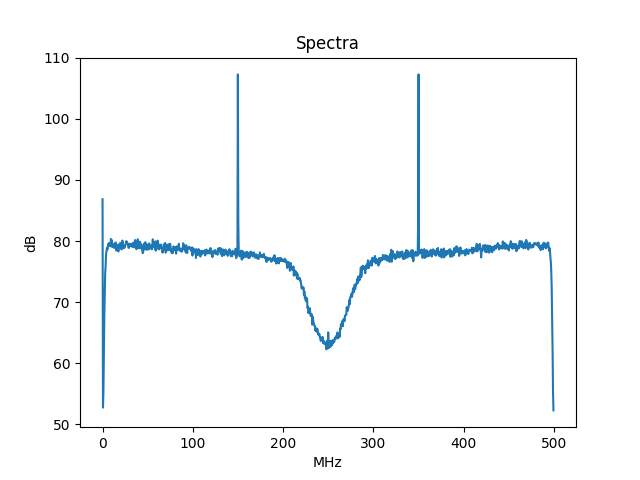

In [8]:
l=dat.shape[0]
df=fs/l
x=np.arange(0,l)*df
fig=plt.figure()
sub=fig.add_subplot(111)
sub.plot(x,10*np.log10(dat))
sub.set_title('Spectra')
sub.set_xlabel('MHz')
sub.set_ylabel('dB')
plt.show()